<a href="https://colab.research.google.com/github/HyeongChanHam/Lung_Cancer_detection/blob/master/UNET%20TP/FP%20%EA%B8%B0%EB%A1%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [227]:
import os
import numpy as np
import random
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from tqdm import tqdm
from skimage.transform import resize


from keras.callbacks import TensorBoard

from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
tf.test.gpu_device_name()

from google.colab import drive
drive.mount('/content/gdrive')

PATH = "gdrive/My Drive/lung_cancer/"
dataset = 'cleaned'
if dataset == 'small':
    img_path = PATH+'small_data/image_small/'
    mask_path = PATH+'small_data/mask_small/'
elif dataset == 'cleaned':
    img_path = PATH + 'cleaned_data/image_cleaned/'
    mask_path = PATH + 'cleaned_data/mask_cleaned/'
else:
    img_path = PATH+'big_data/images/image/'
    mask_path = PATH+'big_data/masks/mask/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
img_path = PATH + 'new_data/image_new/'
mask_path = PATH + 'new_data/mask_new/'
next(os.walk(img_path))[1]

In [0]:
# #sample 100 patients from whole dataset
# import shutil
# path_from = "gdrive/My Drive/lung_cancer/big_data/"
# path_to = "gdrive/My Drive/lung_cancer/small_data/"
# # shutil.copy
# for i in range(1,743):
#     shutil.copy(path_from + 'images/image/'+img_ids[i], path_to +'image_small/'+ img_ids[i])
#     shutil.copy(path_from + 'masks/mask/' + label_ids[i], path_to +'mask_small/'+ label_ids[i])

In [229]:
img_ids = next(os.walk(img_path))[1]
mask_ids = next(os.walk(mask_path))[1]
img_ids.sort()
mask_ids.sort()
print(img_ids)
print(mask_ids)

print("number of images : ",len(img_ids))
print("number of masks : ",len(mask_ids))

assert len(img_ids) == len(mask_ids), "images and mask have different samples"

#TODO, size
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

['LIDC-IDRI-0001', 'LIDC-IDRI-0002', 'LIDC-IDRI-0003', 'LIDC-IDRI-0004', 'LIDC-IDRI-0005', 'LIDC-IDRI-0006', 'LIDC-IDRI-0007', 'LIDC-IDRI-0008', 'LIDC-IDRI-0009', 'LIDC-IDRI-0010', 'LIDC-IDRI-0011', 'LIDC-IDRI-0012', 'LIDC-IDRI-0013', 'LIDC-IDRI-0014', 'LIDC-IDRI-0015', 'LIDC-IDRI-0016', 'LIDC-IDRI-0017', 'LIDC-IDRI-0018', 'LIDC-IDRI-0019', 'LIDC-IDRI-0020', 'LIDC-IDRI-0021', 'LIDC-IDRI-0022', 'LIDC-IDRI-0023', 'LIDC-IDRI-0024', 'LIDC-IDRI-0025', 'LIDC-IDRI-0026', 'LIDC-IDRI-0027', 'LIDC-IDRI-0029', 'LIDC-IDRI-0030', 'LIDC-IDRI-0031', 'LIDC-IDRI-0033', 'LIDC-IDRI-0034', 'LIDC-IDRI-0035', 'LIDC-IDRI-0036', 'LIDC-IDRI-0037', 'LIDC-IDRI-0038', 'LIDC-IDRI-0039', 'LIDC-IDRI-0040', 'LIDC-IDRI-0041', 'LIDC-IDRI-0042', 'LIDC-IDRI-0043', 'LIDC-IDRI-0044', 'LIDC-IDRI-0045', 'LIDC-IDRI-0046', 'LIDC-IDRI-0047', 'LIDC-IDRI-0048', 'LIDC-IDRI-0049', 'LIDC-IDRI-0050', 'LIDC-IDRI-0051', 'LIDC-IDRI-0052', 'LIDC-IDRI-0053', 'LIDC-IDRI-0054', 'LIDC-IDRI-0055', 'LIDC-IDRI-0056', 'LIDC-IDRI-0057', 'LIDC-IDR

In [278]:
#cleaned


# load all data to memory

# X_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)
train_test_split_ratio = 0.2 # test ratio
# train_idx = np.random.choice(img_ids, int(len(img_ids) * (1-train_test_split_ratio)), replace=False)
train_idx = img_ids[:int(len(img_ids)*0.8)]
test_idx = list(set(img_ids) - set(train_idx))

sys.stdout.flush()
# for n, train in tqdm(enumerate(train_idx), total=len(train_idx)):
#     train_imgs = next(os.walk(img_path + train))[2]
#     for _img in train_imgs:
#         path = img_path + train + "/" + _img
#         img = np.expand_dims(imread(path), axis=2)
#         # img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) #TODO
#         X.append(img)

# X_train = np.array(X, dtype=np.uint8)

def read_dataset(path, idx, type):
    if type == 'image':
        X_set = np.zeros((0, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    else:
        X_set = np.zeros((0, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)
    for n, i in tqdm(enumerate(idx), total=len(idx)):
        imgs = next(os.walk(path + i))[2]
        imgs.sort()
        if type == 'image':
            X_ = np.zeros((len(imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
        else:
            X_ = np.zeros((len(imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)
        for idx, _img in enumerate(imgs):
            p = path + i + "/" + _img
            img = np.expand_dims(imread(p), axis=2)
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) #TODO
            X_[idx] = img
        X_set = np.concatenate([X_set, X_], axis=0)

    return X_set

X_train_new = read_dataset(img_path, train_idx, 'image')
X_test_new = read_dataset(img_path, test_idx, 'image')

#normalize
X_train_new = (X_train_new - X_train_new.min()) / (X_train_new.max() - X_train_new.min())
X_test_new = (X_test_new - X_test_new.min()) / (X_test_new.max() - X_test_new.min())


Y_train_new = read_dataset(mask_path, train_idx, 'mask')
Y_test_new = read_dataset(mask_path, test_idx, 'mask')

    # for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
    #     path = img_path +id_
    #     img = np.expand_dims(imread(path),axis=2)
    #     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    #     X_train[n] = img

    # for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    #     mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    #     path = mask_path+id_
    #     label = np.expand_dims(imread(path), axis=2)
    #     mask = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    #     Y_train[n] = mask

# for test in test_idx:
#     for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
#         path = img_path +id_
#         img = np.expand_dims(imread(path),axis=2)
#         img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#         X_train[n] = img

#     for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
#         mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
#         path = mask_path+id_
#         label = np.expand_dims(imread(path), axis=2)
#         mask = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#         Y_train[n] = mask







  0%|          | 0/72 [00:00<?, ?it/s]




  1%|▏         | 1/72 [00:00<00:07,  9.46it/s]




  3%|▎         | 2/72 [00:00<00:13,  5.36it/s]




  4%|▍         | 3/72 [00:00<00:16,  4.30it/s]




  7%|▋         | 5/72 [00:00<00:12,  5.40it/s]




  8%|▊         | 6/72 [00:01<00:11,  5.85it/s]




 10%|▉         | 7/72 [00:01<00:13,  4.87it/s]




 12%|█▎        | 9/72 [00:01<00:10,  6.05it/s]




 14%|█▍        | 10/72 [00:01<00:10,  6.03it/s]




 15%|█▌        | 11/72 [00:02<00:13,  4.41it/s]




 17%|█▋        | 12/72 [00:02<00:17,  3.37it/s]




 18%|█▊        | 13/72 [00:02<00:16,  3.67it/s]




 21%|██        | 15/72 [00:03<00:13,  4.29it/s]




 22%|██▏       | 16/72 [00:03<00:13,  4.05it/s]




 25%|██▌       | 18/72 [00:03<00:11,  4.75it/s]




 26%|██▋       | 19/72 [00:03<00:12,  4.37it/s]




 28%|██▊       | 20/72 [00:04<00:12,  4.22it/s]




 29%|██▉       | 21/72 [00:04<00:10,  4.79it/s]




 31%|███       | 22/72 [00:04<00:09,  5.29it/s]




 32%|███▏      | 23/72 

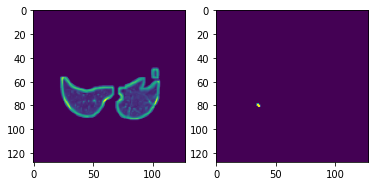

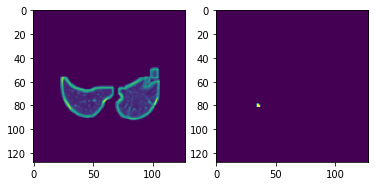

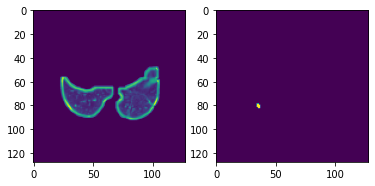

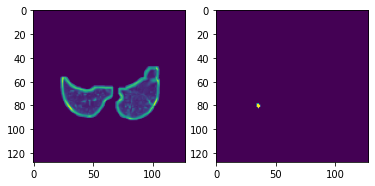

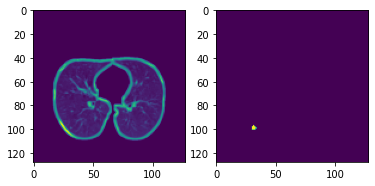

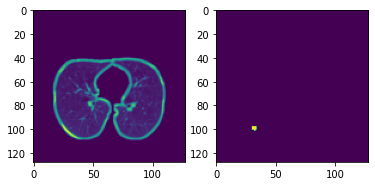

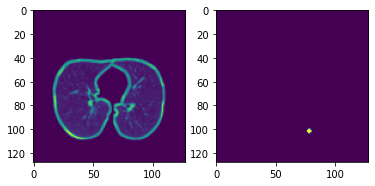

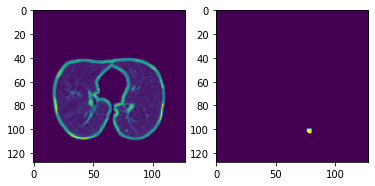

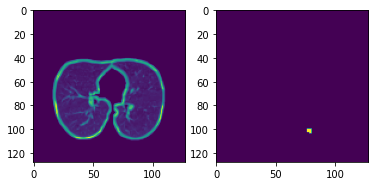

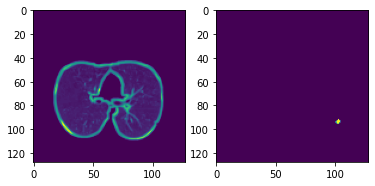

In [279]:
# plt.imshow(X_train[1][:,:,0])
# plt.show()
for i in range(60,70):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(X_train_new[i][:,:,0])
    ax[1].imshow(Y_train_new[i][:,:,0])
    plt.show()

In [213]:
#original

# load all data to memory

# train_test_split_ratio = 0.2 # test ratio
# train_idx = np.random.choice(img_ids, int(len(img_ids) * (1-train_test_split_ratio)), replace=False)
# test_idx = list(set(img_ids) - set(train_idx))

sys.stdout.flush()
# for n, train in tqdm(enumerate(train_idx), total=len(train_idx)):
#     train_imgs = next(os.walk(img_path + train))[2]
#     for _img in train_imgs:
#         path = img_path + train + "/" + _img
#         img = np.expand_dims(imread(path), axis=2)
#         # img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) #TODO
#         X.append(img)

# X_train = np.array(X, dtype=np.uint8)

# def read_dataset(path, idx):
#     X_set = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#     for n, i in tqdm(enumerate(idx), total=len(idx)):
#         imgs = next(os.walk(path + i))[2]
#         X_ = np.zeros((len(imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#         for idx, _img in enumerate(imgs):
#             p = path + i + "/" + _img
#             img = np.expand_dims(imread(p), axis=2)
#             img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) #TODO
#             X_[idx] = img
#         X_set = np.concatenate([X_set, X_], axis=0)

#     return X_set

# X_train = read_dataset(img_path, train_idx)
# X_test = read_dataset(img_path, test_idx)

# #normalize
# X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
# X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())


# Y_train = read_dataset(mask_path, train_idx)
# Y_test = read_dataset(mask_path, test_idx)
# print(X_train.max(), X_test.max(), Y_train.max(), Y_test.max())



X_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)
for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
    path = img_path +id_
    img = np.expand_dims(imread(path),axis=2)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    path = mask_path+id_
    label = np.expand_dims(imread(path), axis=2)
    mask = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask

# for test in test_idx:
#     for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
#         path = img_path +id_
#         img = np.expand_dims(imread(path),axis=2)
#         img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#         X_train[n] = img

#     for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
#         mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
#         path = mask_path+id_
#         label = np.expand_dims(imread(path), axis=2)
#         mask = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#         Y_train[n] = mask




  0%|          | 0/741 [00:00<?, ?it/s]

  1%|          | 8/741 [00:00<00:09, 73.97it/s]

  2%|▏         | 15/741 [00:00<00:10, 72.22it/s]

  3%|▎         | 23/741 [00:00<00:09, 73.00it/s]

  4%|▍         | 31/741 [00:00<00:09, 73.63it/s]

  5%|▌         | 38/741 [00:00<00:09, 71.51it/s]

  6%|▌         | 45/741 [00:00<00:09, 70.92it/s]

  7%|▋         | 53/741 [00:00<00:09, 71.22it/s]

  8%|▊         | 61/741 [00:00<00:09, 72.33it/s]

  9%|▉         | 69/741 [00:00<00:09, 72.54it/s]

 10%|█         | 77/741 [00:01<00:09, 73.26it/s]

 11%|█▏        | 85/741 [00:01<00:09, 70.71it/s]

 13%|█▎        | 93/741 [00:01<00:09, 71.14it/s]

 14%|█▎        | 101/741 [00:01<00:08, 71.91it/s]

 15%|█▍        | 109/741 [00:01<00:09, 69.79it/s]

 16%|█▌        | 117/741 [00:01<00:08, 70.86it/s]

 17%|█▋        | 125/741 [00:01<00:08, 71.98it/s]

 18%|█▊        | 133/741 [00:01<00:08, 72.73it/s]

 19%|█▉        | 141/741 [00:01<00:08, 72.54it/s]

 20%|██        | 149/741 [00:02<00:08, 72.67it/s]

 

In [186]:
X_train.max()

253

250

In [170]:
a = np.expand_dims(np.array([[1,2],[3,4]]), axis=2)
a = np.expand_dims(np.array([[1,2],[3,4]]), axis=2)
b = np.concatenate([a,a], axis=2)
b.shape

(2, 2, 2)

In [0]:
tf.reduce_sum(Y_train[2][:,:,0])
n=0
for i in X_train:
    plt.imshow(i[:,:,0])
    plt.show()
    if n==10:
        break
    n+=1

In [284]:
# Define IoU metric
def IoU(y_true, y_pred):
    y_pred = tf.cast(tf.greater(y_pred, 0.5),tf.float32)
    intersection = tf.reduce_sum(y_true*y_pred)
    union =tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return tf.reduce_sum(y_true) 

# earlystopper = EarlyStopping(patience=10, verbose=0)
checkpointer = ModelCheckpoint('model-dsbowl2020-4.h5', verbose=0, save_best_only=True)

def build_model(act):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x) (inputs)

    activ = act
    c1 = Conv2D(16, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation=activ, kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    opt = Adam(lr = 0.0001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy,metrics=[IoU])

    return model

def model_train(model,_X_train, _Y_train ):
    with tf.device('/device:GPU:0'):
        results = model.fit(_X_train, _Y_train, validation_split=0.1, batch_size=4, epochs=100, 
                        callbacks=[earlystopper, checkpointer], verbose=0)
    return results, model

def draw_fig(results, shuffle, norm, act, opt, loss, avail):
    title = "shuffle : {}, normalization : {}, activation : {}, optimizer : {}, loss function : {}, available prediction : {:.0%}".format(
        shuffle, norm, act, opt, loss, avail)
    fig, ax = plt.subplots(1,2, figsize=(10,3))
    loss = results.history['loss']
    val_loss = results.history['val_loss']
    ax[0].plot(loss, 'r', label='loss')
    ax[0].plot(val_loss,'b',label='val_loss')
    ax[0].legend()
    _IoU = results.history['IoU']
    _val_IoU = results.history['val_IoU']
    ax[1].plot(_IoU, 'g',label='IoU')
    ax[1].plot(_val_IoU, 'c',label='val_IoU')
    ax[1].legend()
    plt.suptitle(title)
    plt.show()

# Predict on train, val and test
def count_valid_pred(model,_X_val, _Y_val):
    model = load_model('model-dsbowl2020-4.h5',{'IoU':IoU})
    preds_val = model.predict(_X_val, verbose=0)

    preds_val_t = (preds_val > 0.5).astype(np.uint8)

    IoU_vec = np.array([])
    '''
    print out images
    '''
    for i in range(10):
        ix = random.randint(0, len(_X_val))
        fig, ax = plt.subplots(1,3,figsize=(10,6))
        ax[0].imshow(_X_val[ix][:,:,0],cmap='gray')
        ax[0].axis('off')
        ax[1].imshow(np.squeeze(preds_val_t[ix][:,:,0]),cmap='gray')

        c = measure.regionprops(preds_val_t[ix][:,0,0])
        print("len : ",len(c))
        ax[1].title.set_text("prediction")
        ax[1].axis('off')
        ax[2].imshow(np.squeeze(_Y_val[ix][:,:,0]),cmap='gray')
        ax[2].title.set_text("ground truth")
        ax[2].axis('off')
        plt.show()
        print("IoU : ",IoU(tf.convert_to_tensor(preds_val_t[ix],tf.float32),tf.convert_to_tensor(_Y_val[ix],tf.float32)).numpy())

    for i in range(len(preds_val_t)):
        IoU_vec = np.append(IoU_vec, IoU(tf.convert_to_tensor(preds_val_t[i],tf.float32),tf.convert_to_tensor(_Y_val[i],tf.float32)).numpy())
    return np.where(IoU_vec>0,1,0).mean()

model = build_model('relu')
with tf.device('/device:GPU:0'):
    results = model.fit(X_train_new, Y_train_new, validation_split=0.1, batch_size=4, epochs=100, 
                    callbacks=[checkpointer], verbose=2)


def iter(shuffle, norm,  opt,act, loss):
    _X_train, _Y_train, _X_val, _Y_val = train_test_split(shuffle, norm, split_ratio = 0.8)
    model = build_model(act)
    results, model = model_train(model,_X_train, _Y_train)
    draw_fig(results, shuffle, norm, act, opt, loss, count_valid_pred(model,_X_val, _Y_val))
    return results

Train on 1008 samples, validate on 113 samples
Epoch 1/100
 - 5s - loss: 0.0550 - IoU: 112.7262 - val_loss: 0.0250 - val_IoU: 144.3448
Epoch 2/100
 - 4s - loss: 0.0104 - IoU: 112.7262 - val_loss: 0.0270 - val_IoU: 144.3448
Epoch 3/100
 - 4s - loss: 0.0096 - IoU: 112.7262 - val_loss: 0.0319 - val_IoU: 144.3448
Epoch 4/100
 - 4s - loss: 0.0088 - IoU: 112.7262 - val_loss: 0.0296 - val_IoU: 144.3448
Epoch 5/100
 - 4s - loss: 0.0080 - IoU: 112.7262 - val_loss: 0.0306 - val_IoU: 144.3448
Epoch 6/100
 - 4s - loss: 0.0074 - IoU: 112.7262 - val_loss: 0.0169 - val_IoU: 144.3448
Epoch 7/100
 - 4s - loss: 0.0067 - IoU: 112.7262 - val_loss: 0.0194 - val_IoU: 144.3448
Epoch 8/100
 - 4s - loss: 0.0061 - IoU: 112.7262 - val_loss: 0.0136 - val_IoU: 144.3448
Epoch 9/100
 - 4s - loss: 0.0056 - IoU: 112.7262 - val_loss: 0.0120 - val_IoU: 144.3448
Epoch 10/100
 - 4s - loss: 0.0053 - IoU: 112.7262 - val_loss: 0.0119 - val_IoU: 144.3448
Epoch 11/100
 - 4s - loss: 0.0049 - IoU: 112.7262 - val_loss: 0.0128 - v

(90.64150943396227, 86.24528301886792)


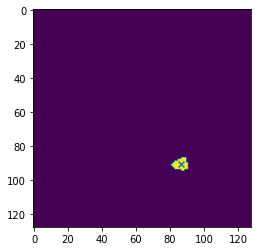

True False


In [283]:
i = 10
plt.imshow(Y_train_new[i][:,:,0])
c = get_centers(Y_train_new[i][:,:,0])[0]
print(c)
plt.scatter(c[1],c[0],marker='x')
plt.show()
print(Y_train_new[i].max(), Y_train_new[i].min())

In [274]:
Y_train[0][:,:,0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

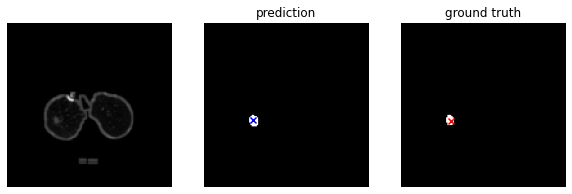

[(76.17647058823529, 38.13725490196079)]
[(75.65, 37.525)]
d^2 : 0.6520273452518213
TP: 1, FP: 0, FN: 0


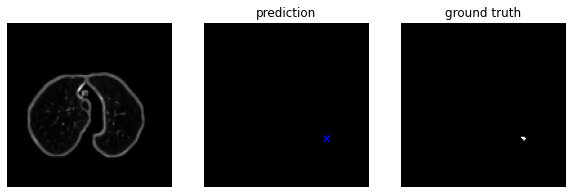

[]
[(89.71428571428571, 94.57142857142857)]
TP: 0, FP: 0, FN: 1


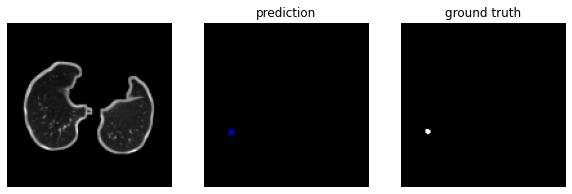

[]
[(84.38461538461539, 20.384615384615383)]
TP: 0, FP: 0, FN: 1


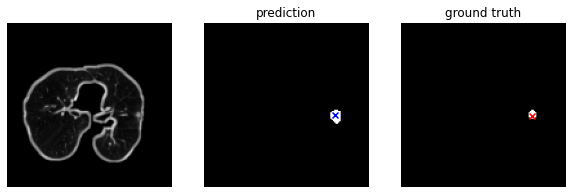

[(72.6376811594203, 101.79710144927536)]
[(71.29411764705883, 101.5)]
d^2 : 1.8934321829106098
TP: 1, FP: 0, FN: 0


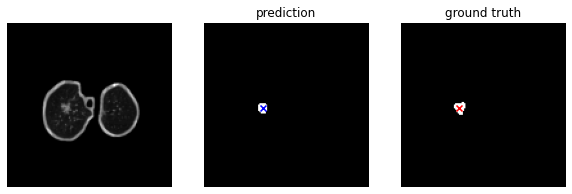

[(66.3265306122449, 45.04081632653061)]
[(66.09677419354838, 45.274193548387096)]
d^2 : 0.1072529396136977
TP: 1, FP: 0, FN: 0


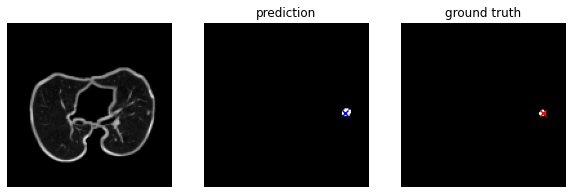

[(69.6470588235294, 110.0)]
[(70.15789473684211, 109.15789473684211)]
d^2 : 0.9700946045682439
TP: 1, FP: 0, FN: 0


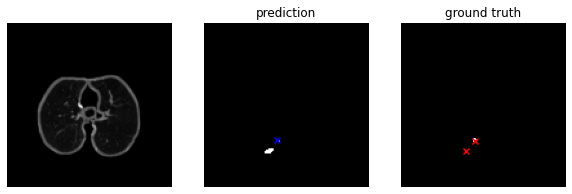

[(92.0, 57.5), (99.57142857142857, 50.04761904761905)]
[(91.0, 56.714285714285715)]
d^2 : 1.6173469387755086
TP: 1, FP: 1, FN: 0


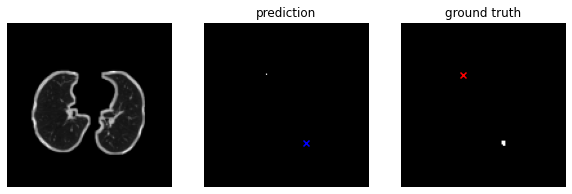

[(40.0, 48.0)]
[(93.36363636363636, 79.0909090909091)]
d^2 : 3814.3223140495866
TP: 0, FP: 1, FN: 1


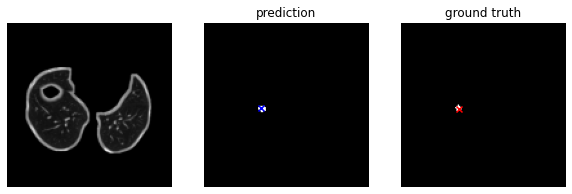

[(66.78260869565217, 44.608695652173914)]
[(66.3125, 44.125)]
d^2 : 0.4549636696597345
TP: 1, FP: 0, FN: 0


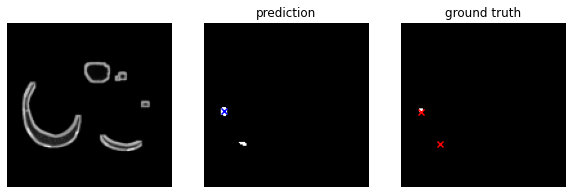

[(68.9, 15.033333333333333), (93.84615384615384, 29.846153846153847)]
[(68.2, 15.0)]
d^2 : 0.4911111111111151
TP: 1, FP: 1, FN: 0


In [287]:
from skimage import measure


X = X_train_new
Y = Y_train_new
model = load_model('model-dsbowl2020-4.h5',{'IoU':IoU})
preds_val = model.predict(X, verbose=0)

preds_val_t = (preds_val > 0.5).astype(np.uint8)

IoU_vec = np.array([])
'''
print out images
'''


def get_centers(image):
    r = []
    for pred_nodule in measure.regionprops(measure.label(image)):
        r.append(pred_nodule.centroid)
    return r


for i in range(10):
    TP=0
    FP=0
    FN=0
    pred = []
    tr = []
    ix = random.randint(0, len(X))
    fig, ax = plt.subplots(1,3,figsize=(10,6))
    ax[0].imshow(X[ix][:,:,0],cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(np.squeeze(preds_val_t[ix][:,:,0]),cmap='gray')



    for center in get_centers(np.squeeze(preds_val_t[ix][:,:,0])):
        ax[2].scatter(center[1], center[0], marker='x', color='r')
        pred.append(center)
    ax[1].title.set_text("prediction")
    ax[1].axis('off')
    ax[2].imshow(np.squeeze(Y[ix][:,:,0]),cmap='gray')
    for center in get_centers(np.squeeze(Y[ix][:,:,0])):
        ax[1].scatter(center[1], center[0], marker='x', color='b')
        tr.append(center)
    ax[2].title.set_text("ground truth")
    ax[2].axis('off')
    plt.show()
    print(pred)
    print(tr)
    
    for p in pred:
        for t in tr:
            dist_sq = pow((p[0] - t[0]),2) + pow((p[1] - t[1]),2)
            print("d^2 : {}".format(dist_sq))
            if dist_sq < 2:
                TP+=1
                tr.remove(t)
    FP = len(pred) - TP
    for t in tr:
        FN+=1
    print(f"TP: {TP}, FP: {FP}, FN: {FN}")



In [0]:
iter_dict = {'shuffle':[True], 'norm':[False,'z',  'mm_norm'],
             'opt':['adam'], 'act':['relu', 'elu']}
opt_dict = {}
opt_dict['adam'] = Adam(lr = 0.0001, beta_1=0.9, beta_2=0.999)
opt_dict['SGD'] = SGD(learning_rate = 0.0001, momentum=0.999)

In [0]:
result2 = {}
for shuffle in iter_dict['shuffle']:
    for norm in iter_dict['norm']:
        for opt in iter_dict['opt']:
            for act in iter_dict['act']:
                for _ in range(3):
                    print("trial {}, {}_{}_{}_{}".format(_+1, shuffle,norm,opt,act))
                    result2["{}_{}_{}_{}".format(shuffle,norm,opt,act)] = iter(shuffle, norm, opt_dict[opt], act, "cross_entropy")
                    print("val_IoU : {}".format(result2["{}_{}_{}_{}".format(shuffle,norm,opt,act)].history['val_IoU'][-1]))


trial 1, True_mm_norm_adam_elu


KeyboardInterrupt: ignored

Train on 532 samples, validate on 60 samples
Epoch 1/100
532/532 [==============================] - 8s 15ms/step - loss: 0.0363 - IoU: 1.6399e-04 - val_loss: 0.0130 - val_IoU: 0.0000e+00
Epoch 2/100
532/532 [==============================] - 6s 12ms/step - loss: 0.0106 - IoU: 6.1128e-05 - val_loss: 0.0164 - val_IoU: 0.0083
Epoch 3/100
532/532 [==============================] - 6s 12ms/step - loss: 0.0100 - IoU: 6.3719e-05 - val_loss: 0.0125 - val_IoU: 0.0048
Epoch 4/100
532/532 [==============================] - 6s 12ms/step - loss: 0.0095 - IoU: 0.0018 - val_loss: 0.0152 - val_IoU: 0.0265
Epoch 5/100
532/532 [==============================] - 6s 12ms/step - loss: 0.0091 - IoU: 0.0026 - val_loss: 0.0091 - val_IoU: 0.0106
Epoch 6/100
532/532 [==============================] - 6s 12ms/step - loss: 0.0086 - IoU: 0.0209 - val_loss: 0.0088 - val_IoU: 0.0399
Epoch 7/100
532/532 [==============================] - 6s 12ms/step - loss: 0.0079 - IoU: 0.0614 - val_loss: 0.0080 - val_IoU: 0.0274
E

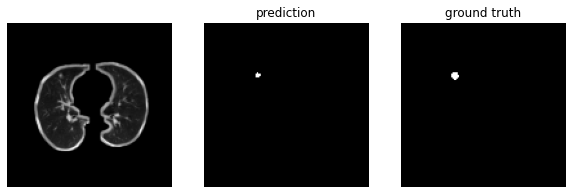

IoU :  0.44444445


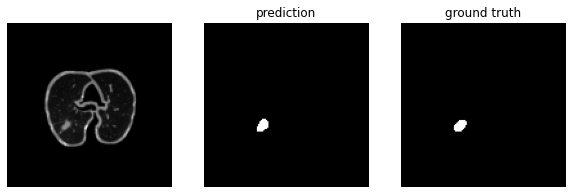

IoU :  0.82191783


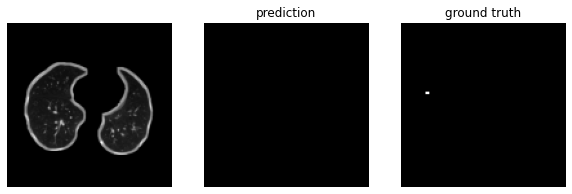

IoU :  0.0


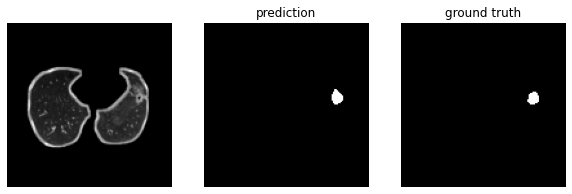

IoU :  0.79012346


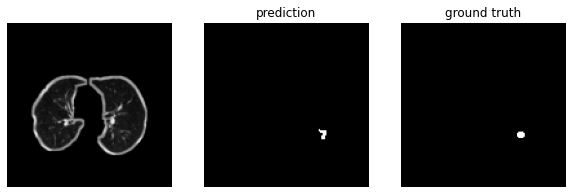

IoU :  0.43243244


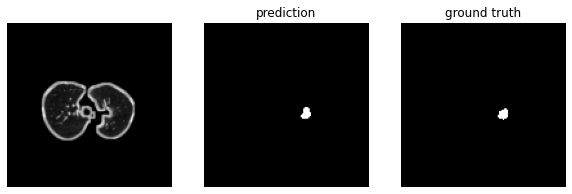

IoU :  0.7586207


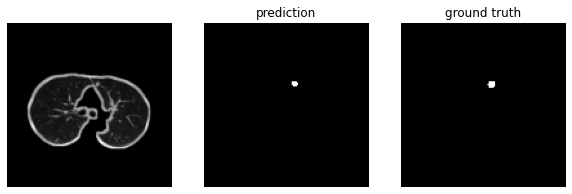

IoU :  0.68


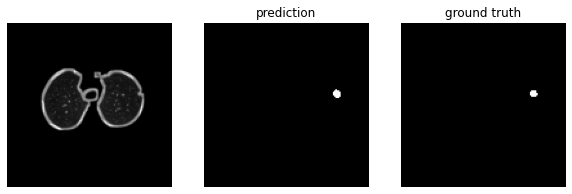

IoU :  0.8064516


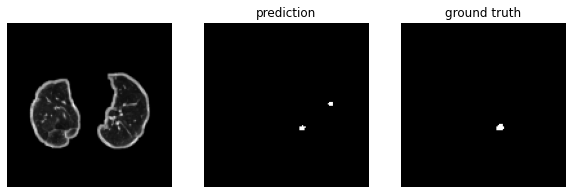

IoU :  0.4117647


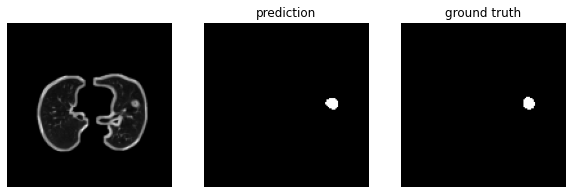

IoU :  0.84


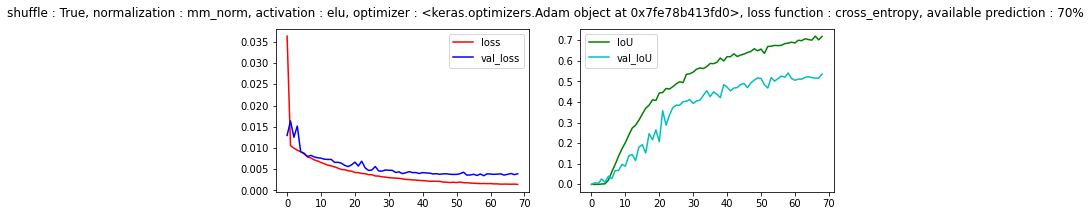

In [0]:
iter(True,'mm_norm' , opt_dict['adam'], 'elu', "cross_entropy")

trial 1, True_mm_norm_adam_relu


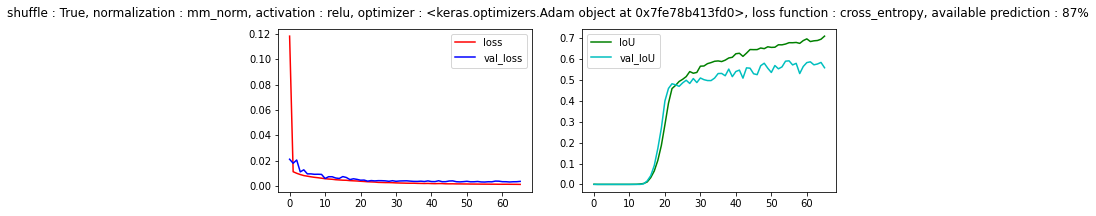

val_IoU : 0.5585997700691223
trial 2, True_mm_norm_adam_relu


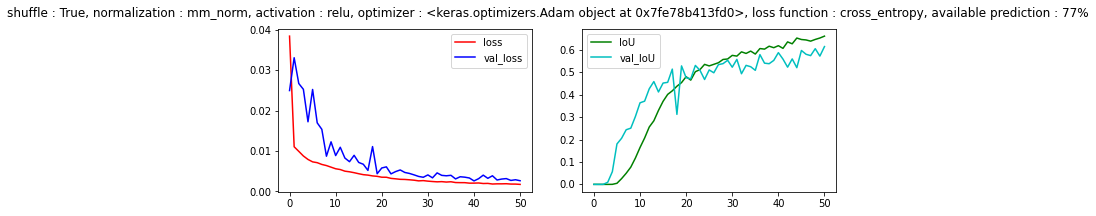

val_IoU : 0.6144168972969055
trial 3, True_mm_norm_adam_relu


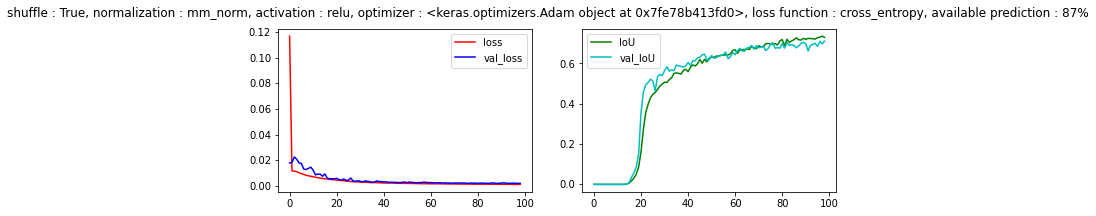

val_IoU : 0.7109771966934204
trial 1, True_mm_norm_adam_elu


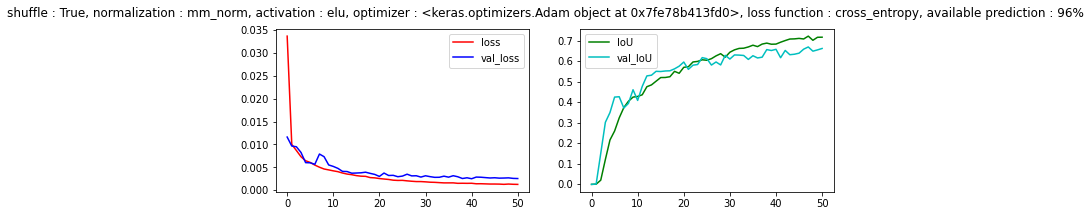

val_IoU : 0.6619313359260559
trial 2, True_mm_norm_adam_elu


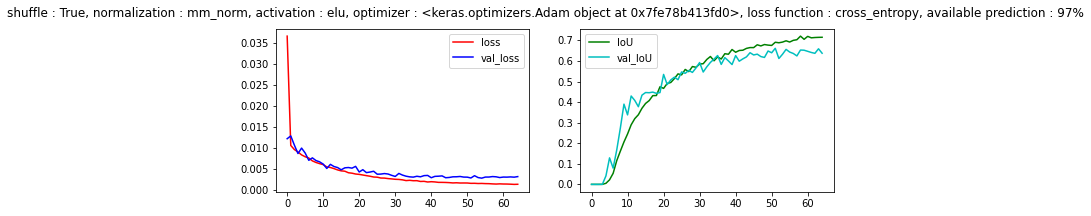

val_IoU : 0.6374111771583557
trial 3, True_mm_norm_adam_elu


In [0]:
iter_dict = {'shuffle':[True], 'norm':['mm_norm'],
             'opt':['adam'], 'act':['relu', 'elu']}
for shuffle in iter_dict['shuffle']:
    for norm in iter_dict['norm']:
        for opt in iter_dict['opt']:
            for act in iter_dict['act']:
                for _ in range(3):
                    print("trial {}, {}_{}_{}_{}".format(_+1, shuffle,norm,opt,act))
                    result2["{}_{}_{}_{}".format(shuffle,norm,opt,act)] = iter(shuffle, norm, opt_dict[opt], act, "cross_entropy")
                    print("val_IoU : {}".format(result2["{}_{}_{}_{}".format(shuffle,norm,opt,act)].history['val_IoU'][-1]))


Download history variables

In [0]:
save_result = result

In [0]:
from google.colab import files

In [0]:
files.download(save_result)

In [0]:
import pickle
save_result['False_False_SGD_elu'].history

In [0]:
files.download('history_False_False_SGD_elu1.json')

In [0]:
!rm False_False_adam_relu_2.json

In [0]:
for i in save_result.keys():
    print(i)

In [0]:
for key in save_result.keys():
    for i in range(2):
        with open('{}_{}.json'.format(key,i+1), 'wb') as f:
            pickle.dump(save_result[key].history,f)
        files.download('{}_{}.json'.format(key,i+1))

In [0]:
a = files.upload()

In [0]:
with open('history_False_False_SGD_elu1 (1).json', 'rb') as f:
    data = pickle.load(f)